## Clustering with Logic Tensor Networks

This is a basic example in which we use LTN for unsupervised clustering in a 2d space of real numbers. We define a theory that encodes the following facts
* every point in the sample set should be assigned to a cluster
* clusters should be to be disjoint
* if two points are close (in terms of euclidian distance), they should belong to the same cluster

We start generating normally distributed samples from $\mathrm{nr\_of\_clusters}$ clusters. We use this to setup the theory and then optimize a loss function defined on the theory.

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# adding parent directory to sys.path (ltnw is in parent dir)
import sys, os
sys.path.insert(0,os.path.normpath(os.path.join(os.path.abspath(''),os.path.pardir)))
import logictensornetworks_wrapper as ltnw
ltnw.ltn.set_universal_aggreg("min")
ltnw.ltn.set_existential_aggregator("max")
ltnw.ltn.set_tnorm("prod")
ltnw.ltn.LAYERS = 4
import logictensornetworks_library as ltnl

Generate $\mathrm{nr\_of\_points\_x\_cluster}$ samples for $\mathrm{nr\_of\_clusters}$ clusters. Every sample is drawn from a normal distribution that is the underlying generator for each cluster. Samples from $\mathbb{R}$^2

In [2]:
nr_of_clusters = 2
nr_of_points_x_cluster = 10
cov = np.array([[.01,0],[0,.01]])

clusters=[]
for i in range(nr_of_clusters):
    mean = np.random.uniform([-1,-1],[1,1],2).astype(np.float32)    
    clusters.append(np.random.multivariate_normal(mean=mean,cov=cov,size=nr_of_points_x_cluster).astype(np.float32) )

Every cluster is represented by a unary predicate $C_0,..C_{\mathrm{nr\_of\_clusters}-1}$

In [3]:
[ltnw.predicate("C_"+str(i),2) for i in range(nr_of_clusters)]
print("\n".join(ltnw.PREDICATES.keys()))

C_0
C_1


We define the theory using a number of variables. First, we define two variables $x,y$ that encompass the complete sample set.

In [4]:
data  = np.concatenate(clusters)
ltnw.variable("?x",data);
ltnw.variable("?y",data);

We define a function close takes an exponential envelope of the euclidian distance of two vectors. It is something like a euclidian similarity.

In [5]:
ltnw.predicate("close",2,ltnl.equal_euclidian);


Next we can define the theory.

In [6]:
ltnw.axiom("forall ?x: %s" % "|".join(["C_%s(?x)" % i for i in range(nr_of_clusters)]))
for i in range(nr_of_clusters):
    ltnw.axiom("exists ?x: C_%s(?x)" % i)
    ltnw.axiom("forall ?x,?y: (C_%s(?x) & close(?x,?y)) -> C_%s(?y)" % (i,i))
    ltnw.axiom("forall ?x,?y: (C_%s(?x) & ~close(?x,?y)) -> (%s)" % (i,"|".join(["C_%s(?y)" % j for j in range(nr_of_clusters) if i!=j])))
    
    for j in range(i+1,nr_of_clusters):
        ltnw.axiom("forall ?x: ~(C_%s(?x) & C_%s(?x))" % (i,j))
print("\n".join(sorted(ltnw.AXIOMS.keys())))


exists ?x: C_0(?x)
exists ?x: C_1(?x)
forall ?x,?y: (C_0(?x) & close(?x,?y)) -> C_0(?y)
forall ?x,?y: (C_0(?x) & ~close(?x,?y)) -> (C_1(?y))
forall ?x,?y: (C_1(?x) & close(?x,?y)) -> C_1(?y)
forall ?x,?y: (C_1(?x) & ~close(?x,?y)) -> (C_0(?y))
forall ?x: C_0(?x)|C_1(?x)
forall ?x: ~(C_0(?x) & C_1(?x))


Initialize the knowledgebase and optimize. Notice that $\mathrm{close}$ is not a very crisp predicate. Therefore reaching high sat levels is basically impossible. Hence, we never really reach sat levels near $1.0$.

In [7]:
ltnw.initialize_knowledgebase(optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01,decay=.9),
                              initial_sat_level_threshold=.5)

ltnw.train(max_epochs=1000);

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.6686284
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.6686284
INFO:logictensornetworks_wrapper:TRAINING 100 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 200 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 300 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 400 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 600 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 700 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 800 sat level -----> nan
INFO:logictensornetworks_wrapper:TRAINING 900 sat level -----> nan
INFO:logictensornet

Visualize results

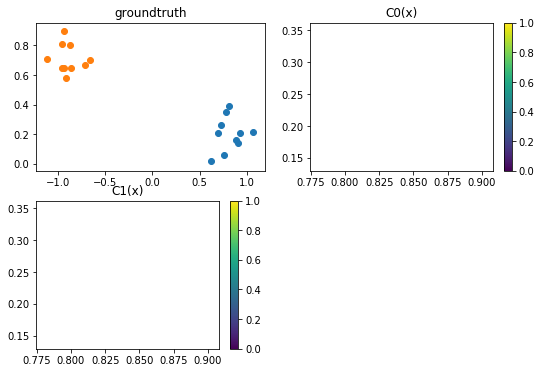

In [8]:
prC = [ltnw.ask("C_%s(?x)" % i) for i in range(nr_of_clusters)]
n = 2
m = (nr_of_clusters + 1) // n + 1

fig = plt.figure(figsize=(3 * 3, m * 3))

fig.add_subplot(m, n, 1)
plt.title("groundtruth")
for c in clusters:
    plt.scatter(c[:, 0], c[:, 1])
data=np.concatenate(clusters)
x0 = data[:, 0]
x1 = data[:, 1]
for i in range(nr_of_clusters):
    fig.add_subplot(m, n, i + 2)
    plt.title("C" + str(i) + "(x)")
    plt.scatter(x0, x1, c=prC[i].T[0])
    plt.scatter(x0[:2], x1[:2], s=0, c=[0, 1])
    plt.colorbar()
plt.show()